In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import unicodedata
import random
import string
import re
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import FunctionTransformer

from sklearn.compose import make_column_transformer

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import f1_score,precision_score,recall_score, roc_auc_score,classification_report,confusion_matrix,average_precision_score,precision_recall_curve,plot_precision_recall_curve
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder


In [2]:
# Load all Jan 2019 /r/worldnews comments, retrieved from Google BigQuery
comments = pd.read_csv("data/reddit_wnews_01-2019.csv")

In [3]:
# Separate intact and removed comments
not_removed_comments = comments[(comments['body']!='[removed]') & (comments['body']!='[deleted]')]
removed_comments = comments[comments['body']=='[removed]']

not_removed_comments['Removed'] = 0

In [4]:
# Load restored comments retrieved from Reddit pushshift API
removed_df = pd.read_csv("data/wnews_removed_comments.csv")

In [5]:
# removed_df_1 = removed_df[removed_df['body']!='[removed]']
removed_df.dropna(inplace=True)
removed_df.reset_index(inplace=True)

In [6]:
# Merge removed comments
comments_2 = pd.merge(comments,removed_df, how='left', on='id', sort=True)

In [7]:
# Replace x vars that have been already filled in by y vars
comments_2.replace({'body_x': '[removed]'},'',inplace=True)
comments_2.replace({'author_x': '[deleted]'},'',inplace=True)

In [8]:
# Replace nans
def replace_missing_vals(df,col_list):
    for col in col_list:
        df[col+'_x'].fillna('',inplace=True)
        df[col+'_y'].fillna('',inplace=True)

col_list = ['body','author']
replace_missing_vals(comments_2,col_list)

In [9]:
# Merge similar columns
def merge_columns(df,col_list):
    for col in col_list:
        #if col+'_x' 
        df[col] = df[[col+'_x',col+'_y']].apply(lambda x: ''.join(x.values.astype(str)),axis=1)

merge_columns(comments_2,col_list)

In [10]:
# Drop columns
def drop_columns(df,drop_list):
    for col in drop_list:
        df.drop([col+'_x',col+'_y'],axis=1,inplace=True)

drop_columns(comments_2,col_list)

In [11]:
# Reformat target 
comments_2['Removed'].fillna(0,inplace=True)
comments_2['Removed'] = comments_2['Removed'].astype(float).astype(int)

In [12]:
# Remove automoderator, missing, and user-deleted comments
comments_3 = comments_2[(comments_2['body']!='[deleted]') & (comments_2['body']!='nan') & (comments_2['body']!='')]
comments_4 = comments_3[comments_3['body']!="Your submission has been automatically removed pending manual approval because your account does not meet the minimum karma or account age requirements of /r/worldnews for submitting from an uncommon domain. \n\nIf you are new to reddit, we suggest you read\n\n* [reddit 101](http://www.reddit.com/r/help/comments/2bx3cj/reddit_101/)\n\n* [How reddit works](http://www.redditblog.com/2014/07/how-reddit-works.html)\n\n* [The rules of /r/worldnews](http://www.reddit.com/r/worldnews/wiki/rules)\n\nYou may also want to review the [Reddit guidelines regarding spam](http://www.reddit.com/help/faq#Whatconstitutesspam) and the [wiki on self-promotion on reddit](http://www.reddit.com/wiki/selfpromotion). \n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/worldnews) if you have any questions or concerns.*"]
comments_5 = comments_4[comments_4['body']!="Users often report submissions from this site and ask us to ban it for sensationalized articles. At /r/worldnews, we oppose blanket banning any news source. Readers have a responsibility to be skeptical, check sources, and comment on any flaws.\n\nYou can help improve this thread by linking to media that verifies or questions this article's claims. Your link could help readers better understand this issue. If you do find evidence that this article or its title are false or misleading, contact the moderators who will review it\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/worldnews) if you have any questions or concerns.*"]
comments_6 = comments_5[(comments_5['author']!='AutoModerator') & (comments_5['author']!='autotldr')]
comments_6.reset_index(inplace=True)

#### Remove block quotes within comments that reference previous comments

In [13]:
# Remove blocked quotes that are responses to previous comments
comments_6['body_no_quotes'] = comments_6['body'].apply(lambda x: re.sub('&gt;.*','',x))

### Flag responses to removed comments

Moderators often additionally remove responses to removed parent comments, regardless of the perceived "offensiveness" of such responses. To account for this, I flag immediate child responses to removed comments. (May revisit this to flag all nested responses)

In [14]:
# For each comment, parent_id refers to the parent comment or post immediately above
# Reformat parent ids to be consistent with comment ids
comments_6['parent_id_2'] = comments_6['parent_id'].apply(lambda x: x[3:])

# Self-join comments with respective parent comments: get only comments that have "parent" comments 
# "_x" vars are parents, "_y" vars are children
comments_6a = comments_6.merge(right=comments_6, left_on='id', right_on='parent_id_2')

In [15]:
# Get all parent ids that have been removed
comments_6b = comments_6a.loc[comments_6a['Removed_x'] == 1]

# List immediate child comment ids of removed parent comments
comm_ids_to_be_removed = comments_6b['id_y'].values.tolist()

In [16]:
# Unique count
len(set(comm_ids_to_be_removed))

18094

In [17]:
# Get immediate children of top-level comments (where parents are posts)
# "t1_" prefix refers to comments
# "t3_" prefix refers to posts
comments_6a['parent_id_x_pref'] = comments_6a['parent_id_x'].apply(lambda x: x[:3])
top_level_rem_comm = comments_6a[(comments_6a['parent_id_x_pref']=='t3_') & (comments_6a['Removed_x'] == 1)]['id_x'].values.tolist()

# Append immediate children of top-level removed comments to those of lower-level ones
tot_comm_ids_removed = top_level_rem_comm + comm_ids_to_be_removed

In [18]:
len(set(tot_comm_ids_removed))

19406

In [19]:
# Flag immediate children of removed comments
comments_6['child_rem_flag'] = comments_6['id'].isin(tot_comm_ids_removed).astype(int)

In [20]:
comments_6['child_rem_flag'].value_counts()

0    827014
1     19406
Name: child_rem_flag, dtype: int64

In [24]:
# TEST CODE: don't use right now
# Map out comment hierarchy
# First find lowest level comments

parent_ids = comments_6['parent_id_2'].values.tolist()

# lowest-level comments (where id != parent id in same table): these comments aren't parents to any other comment
lowest_level_comments = comments_6[~comments_6['id'].isin(parent_ids)]
lowest_level_comments_list = lowest_level_comments['id'].values.tolist()

# level one parents
L1_parent_comments_list = lowest_level_comments['parent_id_2'].values.tolist()
comments_6['L1_parent'] = comments_6.isin(L1_parent_comments_list).any(1).astype(int)
comments_6['L1_removed'] = comments_6[]

# Get entire nesting hierarchy
i = 2
parent_comments_list = L1_parent_comments_list
lst_len = len(parent_comments_list)
while lst_len > 0:
    comment_list = comments_6[comments_6['id'].isin(parent_comments_list)]
    parent_comments_list = comment_list['parent_id_2'].values.tolist()
    lst_len = len(parent_comments_list)
    print(lst_len)
    comments_6[f'L{i}_parent'] = comments_6.isin(parent_comments_list).any(1).astype(int)
    i += 1

In [21]:
# Drop unnecessary columns
comments_6.drop(['index','Unnamed: 0'],axis=1,inplace=True)

In [22]:
# Remove comments that cannot be restored
comments_final = comments_6[comments_6['body']!='[removed]']

In [23]:
comments_final.reset_index(inplace=True)

In [24]:
len(comments_final)

826191

### Username EDA (decide whether or not to use)

In [53]:
# drop obs w/missing usernames
comments_final_auth = comments_final[comments_final['author']!='']

In [54]:
comments_final_auth['author'].nunique()

171964

In [55]:
comments_final_auth['author'].value_counts()

Give_Praise_Unto_Me    768
tau-lepton             715
Abedeus                653
_Serene_               645
chowderheade           645
                      ... 
LilCommunist69420        1
Obi_is_not_Dead          1
Cats_Pyjamaz             1
QuiGonGiveItToYa         1
Taibo                    1
Name: author, Length: 171964, dtype: int64

In [56]:
users_num_tot_comments = comments_final_auth.groupby('author').count()['body']

In [60]:
users_num_tot_comments.value_counts()

1      84069
2      28369
3      14680
4       9062
5       6266
       ...  
187        1
315        1
188        1
189        1
310        1
Name: body, Length: 267, dtype: int64

In [58]:
users_num_removed = comments_final.groupby('author').sum()['Removed']

In [59]:
users_num_removed.value_counts()

0      161843
1        7763
2        1304
3         479
4         198
5         114
6          73
7          57
8          35
9          13
10         11
11         10
12         10
13          9
15          8
14          6
17          4
18          4
16          2
65          2
21          2
22          2
19          2
72          1
33          1
50          1
48          1
46          1
39          1
27          1
31          1
29          1
26          1
24          1
23          1
20          1
118         1
Name: Removed, dtype: int64

In [61]:
# 6.7% of users had at least one removed comment
(172193-161373)/161373

0.06704963035947774

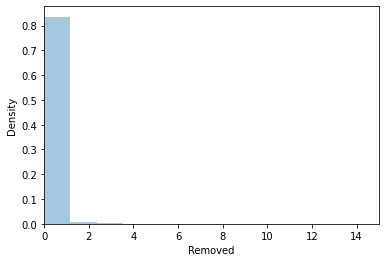

In [87]:
sns.distplot(users_num_removed,bins=100)
plt.xlim([0,15])
plt.ylabel('Density')
plt.show()

In [65]:
users_prop_removed = users_num_removed/users_num_tot_comments

In [66]:
users_prop_removed.value_counts()

0.000000    161842
1.000000      2495
0.500000       875
0.333333       619
0.250000       449
             ...  
0.004608         1
0.046296         1
0.013605         1
0.007286         1
0.003390         1
Length: 525, dtype: int64

In [72]:
users_prop_removed_df = pd.DataFrame(users_prop_removed)

In [73]:
users_prop_removed_df.reset_index(inplace=True)

In [74]:
users_prop_removed_df.rename(columns={0:'prop_rem_comments'},inplace=True)

In [77]:
comments_final_other_feat = comments_final_auth.merge(users_prop_removed_df,how='left',on='author')

In [79]:
comments_final_other_feat.head()

,index,level_0,score,subreddit,parent_id,id,created_utc,Removed,body,author,body_no_quotes,parent_id_2,child_rem_flag,prop_rem_comments
0,0,0,-2,worldnews,t1_eczaid2,eczaysj,1546300802,0,Their kids but not their country. It's still r...,SapphireLance,Their kids but not their country. It's still r...,eczaid2,0,0.0
1,1,1,3,worldnews,t1_ecz3hd0,eczazgm,1546300817,0,&gt;Until they force the Mexicans to pay a rea...,JohnBrennansCoup,\n\nIsn't that one of the key dictates of the ...,ecz3hd0,0,0.0
2,2,2,2,worldnews,t1_eczauvz,eczazr7,1546300824,0,Yeah. It’s called throwing it in an index fund...,NovaStubble,Yeah. It’s called throwing it in an index fund...,eczauvz,0,0.0
3,3,3,8,worldnews,t1_ecz3xxm,eczb0qm,1546300847,0,Guy sounds like a real jerk.,RarePush,Guy sounds like a real jerk.,ecz3xxm,0,0.0
4,4,4,1,worldnews,t1_ecz09q9,eczb0vj,1546300850,0,Thank you!\n\nI always thought the Amish/Menno...,Archmage_Falagar,Thank you!\n\nI always thought the Amish/Menno...,ecz09q9,0,0.0


### Text Preprocessing & Featurization

In [25]:
# Normalize text
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return only_ascii.decode()

# comments_final['body_2'] = comments_final['body'].apply(remove_accents)
comments_final['body_2'] = comments_final['body_no_quotes'].apply(remove_accents)
# top_level_comments['body_2'] = top_level_comments['body_no_quotes'].apply(remove_accents)

In [26]:
# Remove special chars
# May add more chars to list
def remove_special_chars(text):    
    special_chars = ["\n","&gt;"]
    for char in special_chars:   
        text = text.replace(char,"")
    return text

comments_final['body_3'] = comments_final['body_2'].apply(remove_special_chars)
# top_level_comments['body_3'] = top_level_comments['body_2'].apply(remove_special_chars)

In [27]:
# Separate text
content = comments_final['body_3']
content_stay = comments_final[comments_final['Removed']==0]['body_3']
content_removed = comments_final[comments_final['Removed']==1]['body_3']


In [28]:
# Lowercase, remove stopwords, remove punctuation, lemmatize

def clean_text(data):
    stopwords_ = set(STOPWORDS)
    for word in ['u','one','will','well']:         
        stopwords_.add(word)
    
    lines = data.values.tolist()
    data_list = list()
    
    for line in lines:
        tokens = word_tokenize(line)
        tokens = [word.lower() for word in tokens]
        words_only = [word for word in tokens if word.isalpha()]
        words = [word for word in words_only if not word in stopwords_]
        table = str.maketrans('','',string.punctuation)
        no_punc = [word.translate(table) for word in words]
        lemma = WordNetLemmatizer()
        lem = map(lemma.lemmatize,words)
        data_list.append(lem)   

    data_clean = [' '.join(doc) for doc in data_list]
    data_list = [doc.split() for doc in data_clean]
    return data_list,data_clean

data_list,data_clean = clean_text(content)
data_stay_list,data_stay = clean_text(content_stay)
data_removed_list,data_removed = clean_text(content_removed)

In [29]:
len(data_clean)

826191

In [30]:
len(comments_final)

826191

In [31]:
# Save cleaned comments
comments_final.to_pickle("data/comments_final_pt2")

In [32]:
data_clean_df = pd.DataFrame(data_clean)
data_clean_df.to_csv("data/data_clean_pt2.csv")

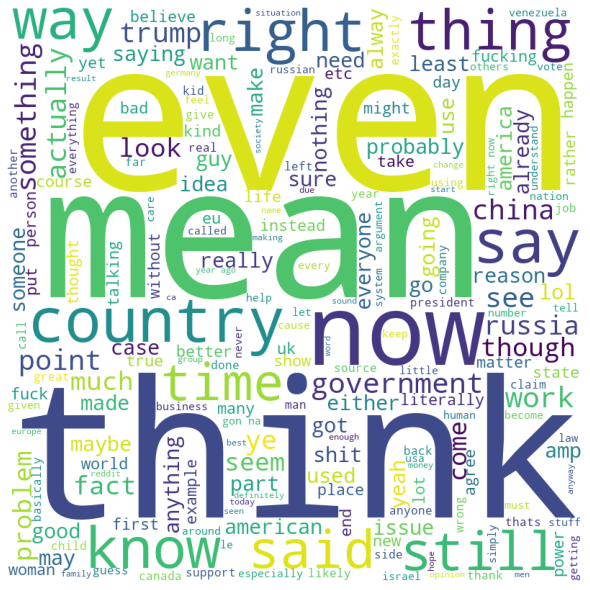

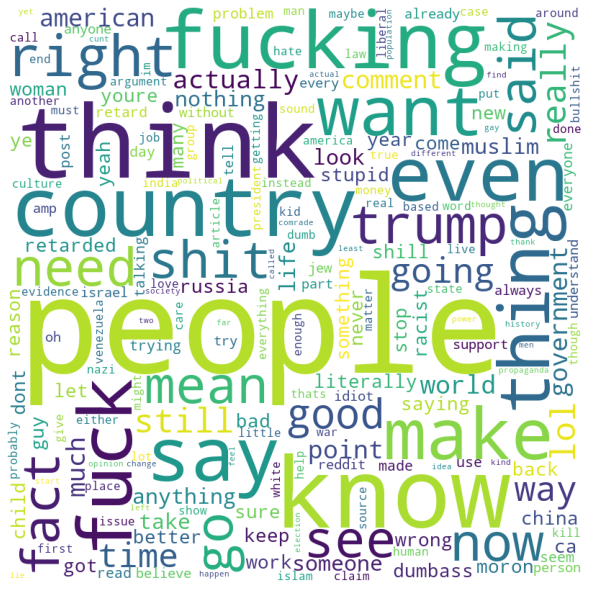

In [96]:
# word cloud w/child comments removed
def word_cloud(corpus_list):
    comment_words = '' 
    stopwords = set(STOPWORDS)
    for word in ['u','one','will','well']:
        stopwords.add(word)

    for i in corpus_list:
        comment_words += " ".join(i)+" "

    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words) 
                       
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show()

#word_cloud(data_list)
word_cloud(data_stay_list)
word_cloud(data_removed_list)

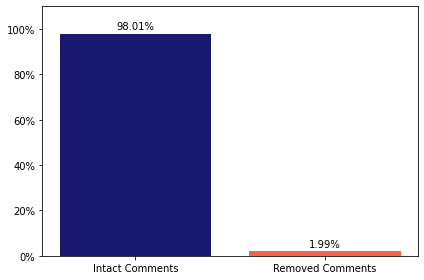

In [97]:
y = comments_final['Removed'].to_numpy()

fig,ax = plt.subplots()

def bar_labels_perc(rects):
    for rect in rects:
        height = rect.get_height()
        plt.annotate(
        f'{round(float(height)*100,2)}%',                     
        (rect.get_x() + rect.get_width()/2, height),         
        xytext=(0, 2),         
        textcoords="offset points", 
        ha='center',                
        va='bottom') 

rect1 = plt.bar("Intact Comments",(len(y)-y.sum())/len(y), color='midnightblue')
rect2 = plt.bar("Removed Comments",y.sum()/len(y), color='tomato')

bar_labels_perc(rect1)
bar_labels_perc(rect2)


ax.set_ylim(0,1.1)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
fig.tight_layout()
plt.show()

### Word Length EDA

In [33]:
# Import data
data_clean_df = pd.read_csv("data/data_clean_pt2.csv")
data_clean_df.drop('Unnamed: 0',axis=1,inplace=True)
data_clean = data_clean_df.values.tolist()
data_clean = [val for sublist in data_clean for val in sublist]

In [34]:
comments_final = pd.read_pickle("data/comments_final_pt2")

In [35]:
comments_final['char_length'] = comments_final['body'].str.len()
comments_final['word_length'] = comments_final['body'].str.split().str.len()

In [36]:
comments_final['word_length'].value_counts()[:20]

7     25462
6     25387
8     24931
9     24441
5     24161
10    23398
4     22786
11    22656
12    21595
13    20866
3     20153
14    19807
15    19114
16    18307
1     18264
17    17373
18    16675
2     16193
19    15911
20    15079
Name: word_length, dtype: int64

In [38]:
comments_final['char_length'].value_counts()[:20]

38    4632
28    4562
43    4531
35    4506
37    4489
42    4483
41    4483
40    4471
36    4449
33    4445
31    4438
39    4426
34    4407
44    4406
30    4397
32    4392
48    4369
45    4330
27    4324
46    4321
Name: char_length, dtype: int64

In [39]:
word_len = comments_final['word_length'].values.tolist()

### Remove Websites and comments that are just stopwords (replaced with blanks)

In [40]:
# Import data
data_clean_df = pd.read_csv("data/data_clean_pt2.csv")
data_clean_df.drop('Unnamed: 0',axis=1,inplace=True)
data_clean = data_clean_df.values.tolist()
data_clean = [val for sublist in data_clean for val in sublist]

In [41]:
len(data_clean)

826191

In [42]:
len(comments_final)

826191

In [43]:
new_lst = []
r_idx = list()
for idx,line in enumerate(data_clean):
    if isinstance(line,str):
        continue
    else:
        r_idx.append(idx)


In [44]:
len(r_idx)

9734

In [45]:
comments_final.drop(['level_0','index'],inplace=True,axis=1)

In [46]:
comments_final.reset_index(inplace=True)

In [47]:
lst = list()
not_str = list()
for idx,line in enumerate(pd.DataFrame(data_clean).values.tolist()):
    if 'http' in line or 'https' in line or 'www' in line:
        r_idx.append(idx)
        lst.append(line)
    else:
        continue
#     if not isinstance(line,str):
#         not_str.append(line)

In [48]:
len(r_idx)

12140

In [49]:
comments_final.reset_index(inplace=True)

In [50]:
comments_final.drop(r_idx,inplace=True)

In [51]:
data_clean_df.drop(r_idx,inplace=True)

In [52]:
len(comments_final)

814051

In [53]:
len(data_clean_df)

814051

In [54]:
data_clean_no_sites = [val for sublist in data_clean_df.values.tolist() for val in sublist]

In [55]:
len(data_clean_no_sites)

814051

### Test Models

#### Method 1: Dropped immediate child responses to removed comments, removed comments that are just websites

In [201]:
# Method 1: Drop responses to removed comments
comments_final.drop(['level_0','index'],inplace=True,axis=1)
comments_final.reset_index(inplace=True)
idx = comments_final.index[comments_final['id'].isin(tot_comm_ids_removed)].tolist()
comments_final_rem = comments_final[~comments_final['id'].isin(tot_comm_ids_removed)]

In [202]:
data_clean_no_sites_df = pd.DataFrame(data_clean_no_sites)

In [210]:
data_clean_no_sites_df.drop(idx,inplace=True)

In [211]:
data_clean_no_sites_rem = [val for sublist in data_clean_no_sites_df.values.tolist() for val in sublist]

In [188]:
y = comments_final_rem['Removed'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
     data_clean_no_sites_rem,y, test_size = 0.2, random_state = 0)

X_train = np.array(X_train)
X_test = np.array(X_test)

In [140]:
# dummy classifier
vect = TfidfVectorizer()
x_train_ = vect.fit_transform(X_train)
x_test_ = vect.transform(X_test)

dc = DummyClassifier(random_state=0)
dc.fit(x_train_, y_train)

pred_test = dc.predict(x_test_)
f1 = f1_score(y_test,pred_test,average=None)
roc = roc_auc_score(y_test,pred_test,average=None)
print(classification_report(y_test,pred_test))
print(confusion_matrix(y_test,pred_test))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    155943
           1       0.02      0.02      0.02      3206

    accuracy                           0.96    159149
   macro avg       0.50      0.50      0.50    159149
weighted avg       0.96      0.96      0.96    159149

[[152876   3067]
 [  3150     56]]


In [145]:
# logistic regression
lr = LogisticRegression(random_state=0,class_weight='balanced')
lr.fit(x_train_, y_train)

lr_pred_test = lr.predict(x_test_)
f1 = f1_score(y_test,lr_pred_test,average=None)
roc = roc_auc_score(y_test,lr_pred_test,average=None)
print(classification_report(y_test,lr_pred_test))
print(confusion_matrix(y_test,lr_pred_test))

              precision    recall  f1-score   support

           0       0.99      0.87      0.93    155943
           1       0.09      0.60      0.15      3206

    accuracy                           0.86    159149
   macro avg       0.54      0.73      0.54    159149
weighted avg       0.97      0.86      0.91    159149

[[135313  20630]
 [  1288   1918]]


In [141]:
rf = RandomForestClassifier(random_state=0,n_estimators=5)
rf.fit(x_train_, y_train)

rf_pred_test = rf.predict(x_test_)
f1 = f1_score(y_test,rf_pred_test,average=None)
roc = roc_auc_score(y_test,rf_pred_test,average=None)
print(classification_report(y_test,rf_pred_test))
print(confusion_matrix(y_test,rf_pred_test))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    155943
           1       0.45      0.15      0.22      3206

    accuracy                           0.98    159149
   macro avg       0.72      0.57      0.60    159149
weighted avg       0.97      0.98      0.97    159149

[[155384    559]
 [  2740    466]]


In [149]:
nb = ComplementNB()
nb.fit(x_train_, y_train)

nb_pred_test = nb.predict(x_test_)
f1 = f1_score(y_test,nb_pred_test,average=None)
roc = roc_auc_score(y_test,nb_pred_test,average=None)
print(classification_report(y_test,nb_pred_test))
print(confusion_matrix(y_test,nb_pred_test))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    155943
           1       0.09      0.12      0.10      3206

    accuracy                           0.96    159149
   macro avg       0.54      0.55      0.54    159149
weighted avg       0.96      0.96      0.96    159149

[[152165   3778]
 [  2830    376]]


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.08')

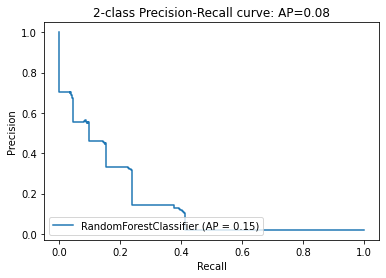

In [144]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, rf_pred_test)


disp = plot_precision_recall_curve(rf, x_test_, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.06')

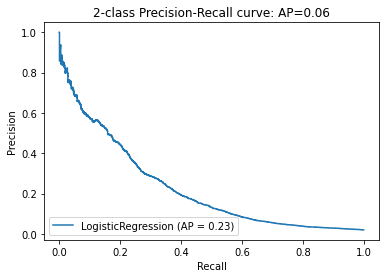

In [146]:
average_precision = average_precision_score(y_test, lr_pred_test)


disp = plot_precision_recall_curve(lr, x_test_, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

#### Method 2: Add "child_rem_flag" variable to tf-idx matrix, remove comments that are just websites

In [56]:
comments_final.to_pickle('data/comments_final_child_flag')

In [57]:
data_clean_no_sites_df = pd.DataFrame(data_clean_no_sites)
data_clean_no_sites_df.to_csv('data/data_clean_child_flag.csv')

In [58]:
data_clean_no_sites_df = pd.read_csv('data/data_clean_child_flag.csv')

In [59]:
data_clean_no_sites_df.drop('Unnamed: 0',axis=1,inplace=True)
data_clean_no_sites_ = data_clean_no_sites_df.values.tolist()
data_clean_no_sites = [val for sublist in data_clean_no_sites_ for val in sublist]

In [60]:
comments_final = pd.read_pickle('data/comments_final_child_flag')

In [61]:
# data_clean_no_sites_df = pd.DataFrame(data_clean_no_sites)

In [62]:
comments_final.drop(['level_0','index'],inplace=True,axis=1)
comments_final.reset_index(inplace=True)

In [65]:
data_clean_no_sites_df.rename(columns={'0':'final_text'},inplace=True)

In [66]:
data_clean_no_sites_df_concat = pd.concat([comments_final,data_clean_no_sites_df],axis=1)

In [102]:
data_clean_no_sites_df_concat.reset_index(inplace=True)

In [103]:
len(data_clean_no_sites_df_concat)

814051

In [104]:
len(comments_final)

814051

In [106]:
data_clean_no_sites_df_concat

,level_0,index,score,subreddit,parent_id,id,created_utc,Removed,body,author,body_no_quotes,parent_id_2,child_rem_flag,body_2,body_3,char_length,word_length,final_text
0,0,0,-2,worldnews,t1_eczaid2,eczaysj,1546300802,0,Their kids but not their country. It's still r...,SapphireLance,Their kids but not their country. It's still r...,eczaid2,0,Their kids but not their country. It's still r...,Their kids but not their country. It's still r...,90,17,kid country still running problem fix
1,1,1,3,worldnews,t1_ecz3hd0,eczazgm,1546300817,0,&gt;Until they force the Mexicans to pay a rea...,JohnBrennansCoup,\n\nIsn't that one of the key dictates of the ...,ecz3hd0,0,\n\nIsn't that one of the key dictates of the ...,Isn't that one of the key dictates of the USMC...,166,30,key dictate usmca replacing nafta
2,2,2,2,worldnews,t1_eczauvz,eczazr7,1546300824,0,Yeah. It’s called throwing it in an index fund...,NovaStubble,Yeah. It’s called throwing it in an index fund...,eczauvz,0,Yeah. Its called throwing it in an index fund ...,Yeah. Its called throwing it in an index fund ...,281,56,yeah called throwing index fund letting compou...
3,3,3,8,worldnews,t1_ecz3xxm,eczb0qm,1546300847,0,Guy sounds like a real jerk.,RarePush,Guy sounds like a real jerk.,ecz3xxm,0,Guy sounds like a real jerk.,Guy sounds like a real jerk.,28,6,guy sound real jerk
4,4,4,1,worldnews,t1_ecz09q9,eczb0vj,1546300850,0,Thank you!\n\nI always thought the Amish/Menno...,Archmage_Falagar,Thank you!\n\nI always thought the Amish/Menno...,ecz09q9,0,Thank you!\n\nI always thought the Amish/Menno...,Thank you!I always thought the Amish/Mennonite...,247,43,thank always thought folk american thing surpr...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814046,814046,826186,1,worldnews,t1_efhaqyq,efhctl0,1548979136,0,They aren’t “breaking the law.” The phrase for...,Vorenvs,They aren’t “breaking the law.” The phrase for...,efhaqyq,0,They arent breaking the law. The phrase for no...,They arent breaking the law. The phrase for no...,453,72,arent breaking law phrase following internatio...
814047,814047,826187,0,worldnews,t1_efhatqy,efhctqh,1548979141,0,They've *always* been white. The idea that the...,nybbleth,They've *always* been white. The idea that the...,efhatqy,0,They've *always* been white. The idea that the...,They've *always* been white. The idea that the...,129,22,always white idea specifically american lunacy...
814048,814048,826188,-17,worldnews,t1_efhare5,efhcuae,1548979157,0,Pretty sure the grand jury isn’t like a normal...,taysteekakes,Pretty sure the grand jury isn’t like a normal...,efhare5,0,Pretty sure the grand jury isnt like a normal ...,Pretty sure the grand jury isnt like a normal ...,109,20,pretty sure grand jury isnt normal jury iirc a...
814049,814049,826189,1,worldnews,t1_efh9g8z,efhcvcy,1548979188,0,Although it wasn't mil-surp the NRA does have ...,hunterkiller7,Although it wasn't mil-surp the NRA does have ...,efh9g8z,0,Although it wasn't mil-surp the NRA does have ...,Although it wasn't mil-surp the NRA does have ...,219,43,although nra lot help getting major gun contro...


In [122]:
data_clean_no_sites_df_concat.to_pickle('data/data_clean_child_flag_final.pkl')

In [69]:
rel_cols_df = data_clean_no_sites_df_concat[['final_text','child_rem_flag']]

In [70]:
y = comments_final['Removed'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
     data_clean_no_sites_df_concat,y, test_size = 0.2, random_state = 0)

In [71]:
# Pipeline to encode categorical variables and append to tfidf 
column_trans = ColumnTransformer(
    [('child_rem', OneHotEncoder(dtype='int'),['child_rem_flag']),
     ('tfidf', TfidfVectorizer(), 'final_text')],
    remainder='drop')

In [72]:
x_train_= column_trans.fit_transform(X_train)
# column_trans.get_feature_names()
# column_trans.transform(X_train).toarray()

In [73]:
x_test_ = column_trans.transform(X_test)

In [74]:
dc = DummyClassifier(random_state=0)
dc.fit(x_train_,y_train)
dc_pred_test = dc.predict(x_test_)
dc_f1 = f1_score(y_test,dc_pred_test,average=None)
dc_roc = roc_auc_score(y_test,dc_pred_test,average=None)
print(classification_report(y_test,dc_pred_test))
print(confusion_matrix(y_test,dc_pred_test))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97    157911
           1       0.03      0.03      0.03      4900

    accuracy                           0.94    162811
   macro avg       0.50      0.50      0.50    162811
weighted avg       0.94      0.94      0.94    162811

[[153187   4724]
 [  4737    163]]


In [75]:
lr = LogisticRegression(random_state=0)
lr.fit(x_train_,y_train)
lr_pred_test = lr.predict(x_test_)
lr_f1 = f1_score(y_test,lr_pred_test,average=None)
lr_roc = roc_auc_score(y_test,lr_pred_test,average=None)
print(classification_report(y_test,lr_pred_test))
print(confusion_matrix(y_test,lr_pred_test))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    157911
           1       0.59      0.22      0.32      4900

    accuracy                           0.97    162811
   macro avg       0.78      0.61      0.65    162811
weighted avg       0.96      0.97      0.97    162811

[[157158    753]
 [  3813   1087]]


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.15')

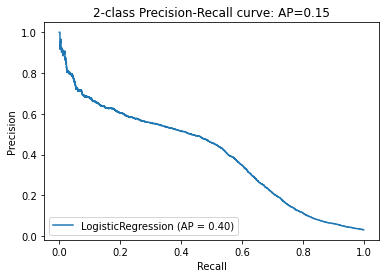

In [80]:
average_precision_lr = average_precision_score(y_test, lr_pred_test)
disp = plot_precision_recall_curve(lr, x_test_, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision_lr))

In [81]:
rf = RandomForestClassifier(random_state=0,n_estimators=5)
rf.fit(x_train_,y_train)
rf_pred_test = rf.predict(x_test_)
rf_f1 = f1_score(y_test,rf_pred_test,average=None)
rf_roc = roc_auc_score(y_test,rf_pred_test,average=None)
print(classification_report(y_test,rf_pred_test))
print(confusion_matrix(y_test,rf_pred_test))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98    157911
           1       0.50      0.26      0.34      4900

    accuracy                           0.97    162811
   macro avg       0.74      0.62      0.66    162811
weighted avg       0.96      0.97      0.97    162811

[[156661   1250]
 [  3649   1251]]


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.15')

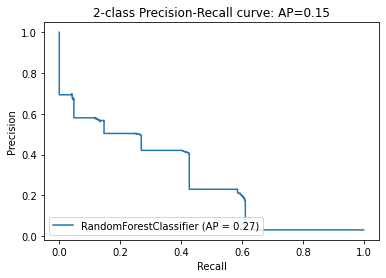

In [82]:
average_precision_rf = average_precision_score(y_test, rf_pred_test)
disp = plot_precision_recall_curve(rf, x_test_, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision_rf))

In [83]:
gb = GradientBoostingClassifier(random_state=0,n_estimators=5)
gb.fit(x_train_,y_train)
gb_pred_test = gb.predict(x_test_)
f1 = f1_score(y_test,gb_pred_test,average=None)
roc = roc_auc_score(y_test,gb_pred_test,average=None)
print(classification_report(y_test,gb_pred_test))
print(confusion_matrix(y_test,gb_pred_test))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    157911
           1       0.73      0.01      0.01      4900

    accuracy                           0.97    162811
   macro avg       0.85      0.50      0.50    162811
weighted avg       0.96      0.97      0.96    162811

[[157900     11]
 [  4870     30]]


In [85]:
nb = ComplementNB()
nb.fit(x_train_,y_train)
nb_pred_test = nb.predict(x_test_)
f1 = f1_score(y_test,nb_pred_test,average=None)
roc = roc_auc_score(y_test,nb_pred_test,average=None)
print(classification_report(y_test,nb_pred_test))
print(confusion_matrix(y_test,nb_pred_test))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    157911
           1       0.39      0.32      0.35      4900

    accuracy                           0.96    162811
   macro avg       0.68      0.65      0.67    162811
weighted avg       0.96      0.96      0.96    162811

[[155430   2481]
 [  3335   1565]]


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.14')

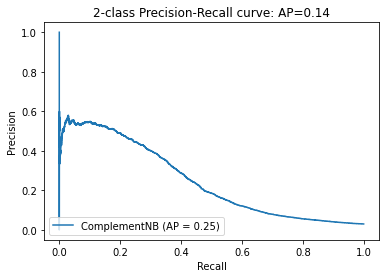

In [86]:
average_precision_nb = average_precision_score(y_test, nb_pred_test)
disp = plot_precision_recall_curve(nb, x_test_, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision_nb))

### Bigrams

In [107]:
column_trans_bigrams = ColumnTransformer(
    [('child_rem', OneHotEncoder(dtype='int'),['child_rem_flag']),
     ('tfidf', TfidfVectorizer(ngram_range=(2,2)), 'final_text')],
    remainder='drop')

In [109]:
x_train_bigrams = column_trans_bigrams.fit_transform(X_train)
x_test_bigrams = column_trans_bigrams.transform(X_test)

In [110]:
lr_bi = LogisticRegression(random_state=0)
lr_bi.fit(x_train_bigrams,y_train)
lr_bi_pred_test = lr_bi.predict(x_test_bigrams)
lr_bi_f1 = f1_score(y_test,lr_bi_pred_test,average=None)
lr_bi_roc = roc_auc_score(y_test,lr_bi_pred_test,average=None)
print(classification_report(y_test,lr_bi_pred_test))
print(confusion_matrix(y_test,lr_bi_pred_test))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99    157911
           1       0.57      0.12      0.19      4900

    accuracy                           0.97    162811
   macro avg       0.77      0.56      0.59    162811
weighted avg       0.96      0.97      0.96    162811

[[157484    427]
 [  4330    570]]


In [112]:
# rf_bi = RandomForestClassifier(random_state=0,n_estimators=5)
# rf_bi.fit(x_train_bigrams,y_train)
# rf_bi_pred_test = rf_bi.predict(x_test_bigrams)
# rf_bi_f1 = f1_score(y_test,rf_bi_pred_test,average=None)
# rf_bi_roc = roc_auc_score(y_test,rf_bi_pred_test,average=None)
# print(classification_report(y_test,rf_bi_pred_test))
# print(confusion_matrix(y_test,rf_bi_pred_test))

In [22]:
# classifier = Pipeline([
#     ('features', FeatureUnion([
#         ('text', Pipeline([
#             ('vectorizer', CountVectorizer()),
#             ('tfidf', TfidfTransformer()),
#         ])), ('response',Pipeline([
#     ('transformer',  make_column_transformer((OneHotEncoder(), ['child_rem_flag']),))])),
#     ])),
#     ('clf', LogisticRegression(random_state=0)),
# ])

In [23]:
# classifier.fit(X_train, y_train)
# predicted = classifier.predict(X_test)

In [ ]:
# def get_text_length(x):
#     return np.array([len(t) for t in x]).reshape(-1, 1)

# classifier = Pipeline([
#     ('features', FeatureUnion([
#         ('text', Pipeline([
#             ('vectorizer', CountVectorizer(min_df=1,max_df=2)),
#             ('tfidf', TfidfTransformer()),
#         ])),
#         ('length', Pipeline([
#             ('count', FunctionTransformer(get_text_length, validate=False)),
#         ]))
#     ])),
#     ('clf', LogisticRegression)])

# classifier.fit(X_train, y_train)
# predicted = classifier.predict(X_test)
# predicted
